# Image Classification: Who is Wearing Glasses?



The goal of this notebook is to use classification models to determine if a person is wearing glasses or not. I'll try a CNN and a SVM-classifier. 

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from pathlib import Path

from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Input, Conv2D, MaxPooling2D, Flatten
from keras.layers import Dropout
from keras.utils.np_utils import to_categorical
import keras.backend as K


from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV
from sklearn.datasets import fetch_olivetti_faces
from sklearn.svm import SVC

In [2]:
%matplotlib inline

### Loading the Data

The data I'm using is the Olvetti Faces data set by AT&T. More information and the data itself are available from <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html">scikit learn</a>. 

Briefly, this data set contains a total of 400 images of 40 different people; 10 photos of each person at various angles with different lighting and facial expressions. 

In [3]:
data = fetch_olivetti_faces()

In [4]:
data.data.shape

(400, 4096)

In [5]:
labels = data.target
len(np.unique(labels))

40

In [6]:
data.images.shape

(400, 64, 64)

In [7]:
num_images = data.images.shape[0]        # number of images = 400
image_shape = data.images.shape[1:]      # each image dimension = 64 x 64

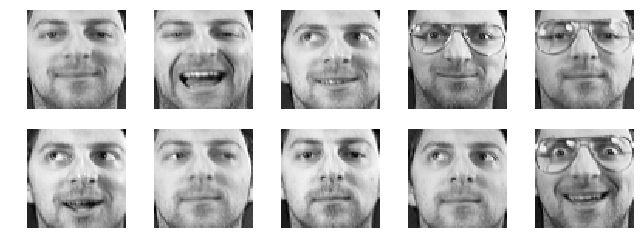

In [9]:
plt.figure(figsize=(11, 4))              # overall figure size

for i in range(60, 70):                  # this guy has the best expressions!
    sub = plt.subplot(2, 5, i-59)        
    # arrangment of the subplots (rows, columns, index [1, -)])
    
    sub.axis("off")
    sub.imshow(data.images[i], cmap='gray');

Notice this is the same guy in these 10 pictures. But in 3 of his 10 pictures he is wearing glasses.

### Glasses: Yes or No?

To add labels indicating who's got glasses and who doesn't, I loop through all the images (it honestly doesn't take that long) and mark the appropriate label to my list, 1 for glasses and 0 for no glasses.

In [10]:
glasses = []
plt.ion()                                # turns on interactive mode making plt.show non-blocking

In [11]:
my_file = Path("glasses.txt")
if my_file.is_file():                    # when the file exists, don't do it again
    glasses = np.loadtxt('glasses.txt', delimiter=',', unpack=True)
else:
    for i in range(num_images):        
        plt.axis("off")
        plt.imshow(data.images[i], cmap='gray');
        plt.show()                             
        glasses.append(input('glasses: '))  # wait for input from the user
        plt.close()
    glasses = list(map(int, glasses))
    np.savetxt('glasses.txt', glasses, fmt='%.1f', delimiter=',')

In [12]:
len(glasses)

400

### Splitting Into Train/Test

I'd like to reserve some new faces for the test set AND make sure that some of them have glasses. I'll reserve the last 8 of the 40 people for my test set.

In [13]:
X_train, X_test, g_train, g_test = data.images[0:320], data.images[320:], glasses[0:320], glasses[320:]

In [14]:
len(X_test)

80

In [15]:
sum(g_test)

22.0

So we'll have 80 images (8 people) in the test set, with 22 of those test images where the person is wearing glasses.

### Convolutional Neural Network

Just for practice I'll use both the sequential model and the functional model in Keras.

NB: Keras requires the images to be in a particular format. I'm using Theano backend which requires channels-first input:

$inputs = Input((1, row_{img}, col_{img}))$

The $1$ is the channel, which in this case is grey-scale. It would be $3$ if these were color images.

In [38]:
X_train = np.reshape(X_train, (len(X_train), 1, 64, 64))
X_test = np.reshape(X_test, (len(X_test), 1, 64, 64))  

In [ ]:
g_train = to_categorical(g_train)
g_test = to_categorical(g_test)

In [18]:
K.set_image_dim_ordering('th')            # when using Theano
input_img = Input(shape=(1, 64, 64)) 
seed = 40

#### Sequential Model 

In [19]:
model_seq = Sequential()
model_seq.add(Conv2D(32, (3, 3), input_shape=(1, 64, 64)))
model_seq.add(Activation('relu'))
model_seq.add(MaxPooling2D(pool_size=(2, 2))) # max pooling (2,2) halves our inputs

model_seq.add(Conv2D(32, (3, 3)))             # 32 is the number of filters and (3,3) is our stride size
model_seq.add(Activation('relu'))             # so we are applying each filter over a 3x3 pixel area
model_seq.add(MaxPooling2D(pool_size=(2, 2)))

model_seq.add(Conv2D(64, (3, 3)))
model_seq.add(Activation('relu'))
model_seq.add(MaxPooling2D(pool_size=(2, 2)))

model_seq.add(Flatten())                      # this converts our 3D feature maps to 1D feature vectors
model_seq.add(Dense(64))
model_seq.add(Activation('relu'))
model_seq.add(Dropout(0.5, seed=seed))        # sets 50% of our inputs to 0! to prevent parameter over-fitting
model_seq.add(Dense(2))
model_seq.add(Activation('sigmoid'))

model_seq.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [22]:
model_seq.fit(x=X_train, y=g_train, batch_size=68, epochs=10, verbose=1);

Epoch 1/10
320/320 [==============================] - 2s - loss: 0.2492 - acc: 0.9156     
Epoch 2/10
320/320 [==============================] - 1s - loss: 0.2895 - acc: 0.8750     
Epoch 3/10
320/320 [==============================] - 1s - loss: 0.1939 - acc: 0.9438     
Epoch 4/10
320/320 [==============================] - 1s - loss: 0.2901 - acc: 0.8984     
Epoch 5/10
320/320 [==============================] - 1s - loss: 0.1757 - acc: 0.9437     
Epoch 6/10
320/320 [==============================] - 1s - loss: 0.1541 - acc: 0.9547     
Epoch 7/10
320/320 [==============================] - 1s - loss: 0.1095 - acc: 0.9719     
Epoch 8/10
320/320 [==============================] - 1s - loss: 0.1916 - acc: 0.9266     
Epoch 9/10
320/320 [==============================] - 1s - loss: 0.1494 - acc: 0.9422     
Epoch 10/10
320/320 [==============================] - 2s - loss: 0.0808 - acc: 0.9938     


In [23]:
predictions_seq = model_seq.predict(X_test)

In [24]:
score_seq = model_seq.evaluate(X_test, g_test, verbose=0)
print('Test loss:', score_seq[0])
print('Test accuracy:', score_seq[1])

Test loss: 0.118313249946
Test accuracy: 0.975


#### Functional Model 

In [25]:
x = Conv2D(32, (3, 3), activation='relu')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

out = Flatten()(x)
out = Dropout(0.5, seed=seed)(out)

id_output = Dense(2, activation='sigmoid')(out)

model_fun = Model(inputs=input_img, outputs= id_output)
model_fun.compile(loss='binary_crossentropy', optimizer='rmsprop', 
              metrics=['accuracy'])

In [28]:
model_fun.fit(x=X_train, y=g_train, batch_size=68, epochs=10, verbose=1);

Epoch 1/10
320/320 [==============================] - 2s - loss: 0.3876 - acc: 0.8422     
Epoch 2/10
320/320 [==============================] - 2s - loss: 0.3085 - acc: 0.8828     
Epoch 3/10
320/320 [==============================] - 2s - loss: 0.3941 - acc: 0.7875     
Epoch 4/10
320/320 [==============================] - 2s - loss: 0.2814 - acc: 0.8844     
Epoch 5/10
320/320 [==============================] - 2s - loss: 0.2531 - acc: 0.9188     
Epoch 6/10
320/320 [==============================] - 2s - loss: 0.3040 - acc: 0.8656     
Epoch 7/10
320/320 [==============================] - 2s - loss: 0.2007 - acc: 0.9469     
Epoch 8/10
320/320 [==============================] - 2s - loss: 0.1992 - acc: 0.9219     
Epoch 9/10
320/320 [==============================] - 2s - loss: 0.1524 - acc: 0.9688     
Epoch 10/10
320/320 [==============================] - 2s - loss: 0.1853 - acc: 0.9250     


In [29]:
predictions_fun = model_fun.predict(X_test)

In [39]:
score_fun = model_fun.evaluate(X_test, g_test, verbose=0)
print('Test loss:', score_fun[0])
print('Test accuracy:', score_fun[1])

Test loss: 0.14554271698
Test accuracy: 0.96875


### Support Vector Machine

Re-shaping the training and test sets again... This time the SVM wants the input structured as one long array for each observation.

In [40]:
X_train, X_test, g_train, g_test = data.images[0:320], data.images[320:], glasses[0:320], glasses[320:]

In [41]:
X_train = np.reshape(X_train, (len(X_train), -1))
X_test = np.reshape(X_test, (len(X_test), -1))  

In [42]:
X_train.shape

(320, 4096)

To find the optimal parameters for the SVM classifier I'll use the randomized search from sklearn. The parameters we're looking for are $C$ and $gamma$.

$C$ determines how flexible we'll allow the margins to be, high numbers mean very flexible. 

$gamma$ determines how much influence each point will have, low numbers mean very far

In [45]:
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}

In [46]:
clf = RandomizedSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid) 
# rbf is radial basis function or Gaussian kernel for similarity measure

In [47]:
clf = clf.fit(X_train, g_train)

In [48]:
clf.best_estimator_

SVC(C=10000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [49]:
predictions_svm = clf.predict(X_test)

In [51]:
predictions_svm

17.0